<a href="https://colab.research.google.com/github/peterprisinzano/PredictingShelterDemandNYC/blob/main/PredictingShelterDemandNYC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Meta's Prophet: Open Source Software for Time Series Forecasting

## Prophet is effective in capturing complex patterns in time series data like seasonality, additive/multiplicative trends, and the impact of holidays. In this study, Prophet will be applied to forecast homeless shelter demand in New York City. Holidays such as Christmas, as well as the temperature will be included to create the model. The dataset used was obtained from the DHS and contains weekly records from January 2014 to January 2021, showing the total amount of individuals in shelter as well as the temperature. The goal is to build a forecasting model capable of predicting future demand for these homeless shelters in the future, ideally providing accurate estimates on a monthly and annual basis.

In [148]:
%cd /content/drive/MyDrive/Business Analyst course/Predictive Analytics/Prophet

/content/drive/MyDrive/Business Analyst course/Predictive Analytics/Prophet


#Data Loading and Preparation

In [149]:
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid

In [150]:
df = pd.read_csv('DHS_weekly.csv')
df.head()

,Date,Total Individuals in Shelter,Easter,Thanksgiving,Christmas,Temperature
0,1/5/2014,354354,0,0,0,0.848000
1,1/12/2014,358103,0,0,0,3.257143
2,1/19/2014,359491,0,0,0,5.632857
3,1/26/2014,362880,0,0,0,-1.850000
4,2/2/2014,364125,0,0,0,1.177143


In [151]:
#Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format = '%m/%d/%Y')
df['Date']

0     2014-01-05
1     2014-01-12
2     2014-01-19
3     2014-01-26
4     2014-02-02
         ...    
361   2020-12-06
362   2020-12-13
363   2020-12-20
364   2020-12-27
365   2021-01-03
Name: Date, Length: 366, dtype: datetime64[ns]

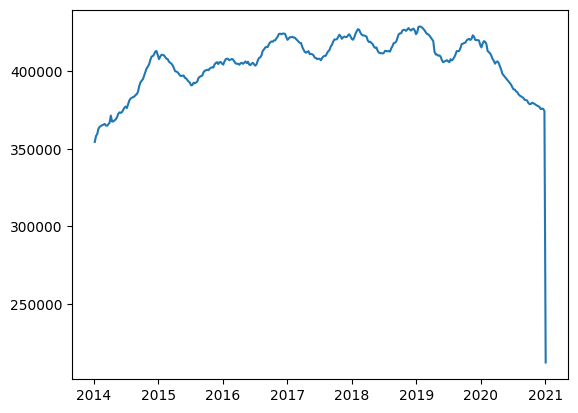

In [152]:
#Shelter demand in NYC over time
plt.plot(df['Date'], df['Total Individuals in Shelter']);

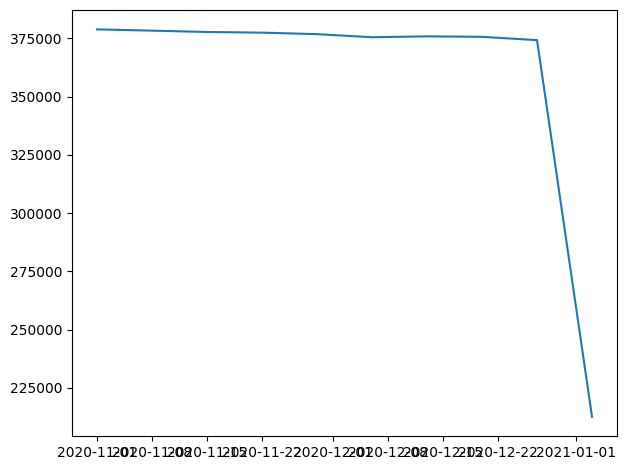

In [153]:
plt.plot(df.tail(10)['Date'], df.tail(10)['Total Individuals in Shelter'])
plt.tight_layout()

In [154]:
#No missing data
df.isnull().sum()

Date                            0
Total Individuals in Shelter    0
Easter                          0
Thanksgiving                    0
Christmas                       0
Temperature                     0
dtype: int64

In [155]:
#Summary stats
df.describe()

,Total Individuals in Shelter,Easter,Thanksgiving,Christmas,Temperature
count,366.000000,366.000000,366.000000,366.000000,366.000000
mean,405042.808743,0.019126,0.019126,0.019126,14.842424
std,19375.509125,0.137154,0.137154,0.137154,8.511113
min,212514.000000,0.000000,0.000000,0.000000,-4.318571
25%,397040.250000,0.000000,0.000000,0.000000,7.503571
50%,408495.000000,0.000000,0.000000,0.000000,14.918571
75%,418908.750000,0.000000,0.000000,0.000000,22.792143
max,428607.000000,1.000000,1.000000,1.000000,28.535714


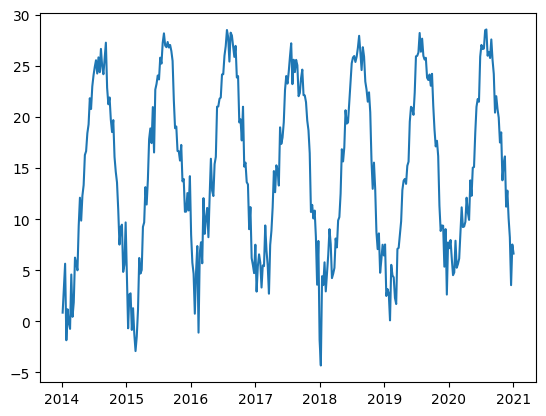

In [156]:
#Checking for abnormal data, temperature is cyclical as predicted
plt.plot(df['Date'], df['Temperature'])

In [157]:
#Need to rename date column to 'ds' and target column to 'y' for input into the Facebook Prophet model

df.rename(columns = {'Date':'ds', 'Total Individuals in Shelter':'y'}, inplace=True)
df.head()

,ds,y,Easter,Thanksgiving,Christmas,Temperature
0,2014-01-05,354354,0,0,0,0.848000
1,2014-01-12,358103,0,0,0,3.257143
2,2014-01-19,359491,0,0,0,5.632857
3,2014-01-26,362880,0,0,0,-1.850000
4,2014-02-02,364125,0,0,0,1.177143


In [158]:
print(df['ds'].head(1))
print(df['ds'].tail(1))

0   2014-01-05
Name: ds, dtype: datetime64[ns]
365   2021-01-03
Name: ds, dtype: datetime64[ns]


In [159]:
#Extract the Easter, Thanksgiving, and Christmas dates

easter_dates = df[df['Easter'] == 1]['ds']
easter = pd.DataFrame({'holiday':'easter', 'ds':easter_dates, 'lower_window':-1, 'upper_window':1})

tg_dates = df[df['Thanksgiving'] == 1]['ds']
tg = pd.DataFrame({'holiday':'thanksgiving', 'ds':tg_dates, 'lower_window':-1, 'upper_window':1})


xmas_dates = df[df['Christmas'] == 1]['ds']
xmas = pd.DataFrame({'holiday':'christmas', 'ds':xmas_dates, 'lower_window':-5, 'upper_window':7})

#Combine the three dataframes into a single holidays dataframe

holidays = pd.concat([easter, tg, xmas])
holidays

,holiday,ds,lower_window,upper_window
15,easter,2014-04-20,-1,1
65,easter,2015-04-05,-1,1
116,easter,2016-03-27,-1,1
171,easter,2017-04-16,-1,1
221,easter,2018-04-01,-1,1
276,easter,2019-04-21,-1,1
327,easter,2020-04-12,-1,1
47,thanksgiving,2014-11-30,-1,1
99,thanksgiving,2015-11-29,-1,1
151,thanksgiving,2016-11-27,-1,1


In [160]:
#Christmas is not always on the 25th due to the data being recorded on a weekly timeframe, as shown below
df[df['Christmas'] == 1]

,ds,y,Easter,Thanksgiving,Christmas,Temperature
51,2014-12-28,410303,0,0,1,9.670000
103,2015-12-27,404725,0,0,1,14.192857
155,2016-12-25,421814,0,0,1,4.711429
208,2017-12-31,420626,0,0,1,-1.812857
260,2018-12-30,423687,0,0,1,6.442857
312,2019-12-29,416756,0,0,1,7.712857
364,2020-12-27,374203,0,0,1,7.510000


In [161]:
df[(df['ds'] > '2014-12-01') & (df['ds'] < '2014-12-31')]

,ds,y,Easter,Thanksgiving,Christmas,Temperature
48,2014-12-07,410642,0,0,0,9.451429
49,2014-12-14,412545,0,0,0,4.831429
50,2014-12-21,412802,0,0,0,5.525714
51,2014-12-28,410303,0,0,1,9.670000


In [162]:
#Remove holidays from the original dataframe

df = df.drop(['Easter','Thanksgiving','Christmas'], axis=1)

#Splitting Data and Instantiating the Prophet Model

In [163]:
#Train test split

test_period = 12 #3 months
train_data = df.iloc[:-test_period, :]
test_data = df.iloc[-test_period:, :]

print(train_data.tail(1))
print(test_data.head(1))

            ds       y  Temperature
353 2020-10-11  378796    19.912857
            ds       y  Temperature
354 2020-10-18  379521    17.487143


In [164]:
m = Prophet(growth = 'linear',
            yearly_seasonality = True,
            weekly_seasonality = False,
            holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05)

m.add_regressor("Temperature", mode="multiplicative")
m.fit(train_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjg2eonk7/n5j85wqs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjg2eonk7/38w9x5fo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69255', 'data', 'file=/tmp/tmpjg2eonk7/n5j85wqs.json', 'init=/tmp/tmpjg2eonk7/38w9x5fo.json', 'output', 'file=/tmp/tmpjg2eonk7/prophet_modelyykh3eif/prophet_model-20240104194321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:43:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:43:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [165]:
#Looking at the regressor coefficients

regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Temperature,multiplicative,14.946504,-0.000021,-0.000021,-0.000021


#Creating a Forecast with the model

In [166]:
#generate a future dataframe
future = m.make_future_dataframe(periods = test_period,
                                 freq = 'W')
future_df = pd.concat([future, df.iloc[:,2:]],
                      axis=1)
future_df

,ds,Temperature
0,2014-01-05,0.848000
1,2014-01-12,3.257143
2,2014-01-19,5.632857
3,2014-01-26,-1.850000
4,2014-02-02,1.177143
...,...,...
361,2020-12-06,10.072857
362,2020-12-13,8.208571
363,2020-12-20,3.535714
364,2020-12-27,7.510000


In [167]:
forecast = m.predict(future_df)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Temperature,Temperature_lower,Temperature_upper,christmas,...,thanksgiving,thanksgiving_lower,thanksgiving_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2014-01-05,352098.078858,353739.571923,360708.362957,352098.078858,352098.078858,0.000303,0.000303,0.000303,0.0,...,0.0,0.0,0.0,0.014268,0.014268,0.014268,0.0,0.0,0.0,357228.308140
1,2014-01-12,353382.649248,355714.148688,362349.915527,353382.649248,353382.649248,0.000251,0.000251,0.000251,0.0,...,0.0,0.0,0.0,0.015440,0.015440,0.015440,0.0,0.0,0.0,358927.724274
2,2014-01-19,354667.219639,357694.122147,363928.468139,354667.219639,354667.219639,0.000200,0.000200,0.000200,0.0,...,0.0,0.0,0.0,0.017551,0.017551,0.017551,0.0,0.0,0.0,360963.049290
3,2014-01-26,355951.790029,359640.924928,366103.856436,355951.790029,355951.790029,0.000361,0.000361,0.000361,0.0,...,0.0,0.0,0.0,0.018768,0.018768,0.018768,0.0,0.0,0.0,362760.753276
4,2014-02-02,357236.360419,360603.505556,367075.969594,357236.360419,357236.360419,0.000296,0.000296,0.000296,0.0,...,0.0,0.0,0.0,0.018109,0.018109,0.018109,0.0,0.0,0.0,363811.365441


In [168]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Temperature', 'Temperature_lower', 'Temperature_upper', 'christmas',
       'christmas_lower', 'christmas_upper', 'easter', 'easter_lower',
       'easter_upper', 'extra_regressors_multiplicative',
       'extra_regressors_multiplicative_lower',
       'extra_regressors_multiplicative_upper', 'holidays', 'holidays_lower',
       'holidays_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'thanksgiving', 'thanksgiving_lower',
       'thanksgiving_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yhat'],
      dtype='object')

In [169]:
forecast[(forecast['thanksgiving'].abs() > 0) & (forecast['ds'] > '2014-01-01') & (forecast['ds'] < '2014-12-31')][['ds','thanksgiving']]

,ds,thanksgiving
47,2014-11-30,-0.000347


In [170]:
preds = forecast['yhat'][-test_period:]
preds

354    392284.605598
355    393028.599283
356    393592.108247
357    393698.702150
358    393527.763828
359    393440.179094
360    393374.462723
361    393589.368567
362    393180.140343
363    392121.070264
364    390105.058587
365    388515.119347
Name: yhat, dtype: float64

In [171]:
#Model forecasting accuracy

print("Mean Individuals in Shelter: ", np.mean(df['y']))
print("SD for Individuals in Shelter: ", np.std(df['y']))
print("RMSE: ",np.sqrt(mean_squared_error(test_data['y'], preds)))

Mean Individuals in Shelter:  405042.8087431694
SD for Individuals in Shelter:  19349.021744987807
RMSE:  53012.10739180397


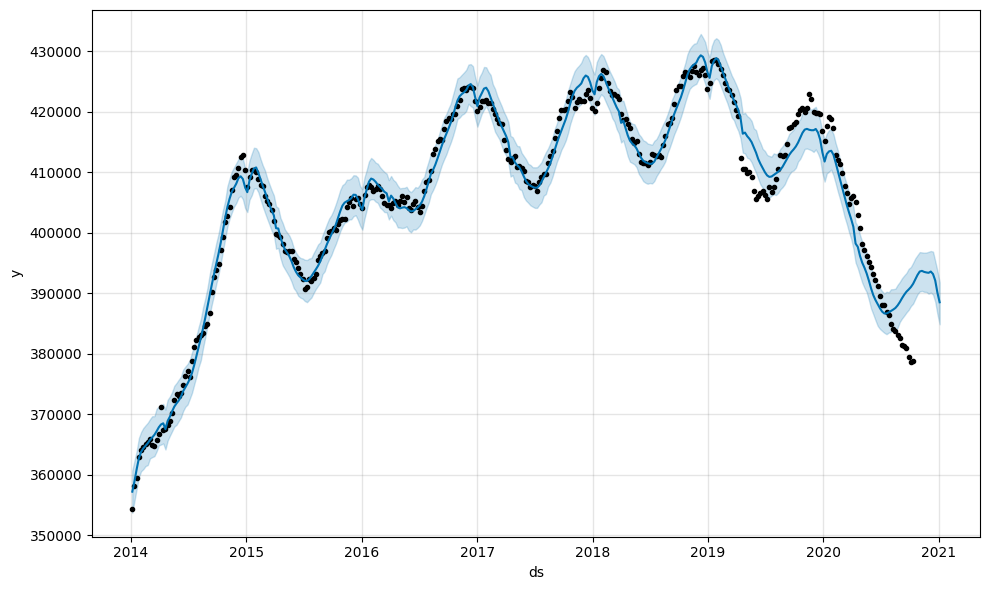

In [172]:
m.plot(forecast);

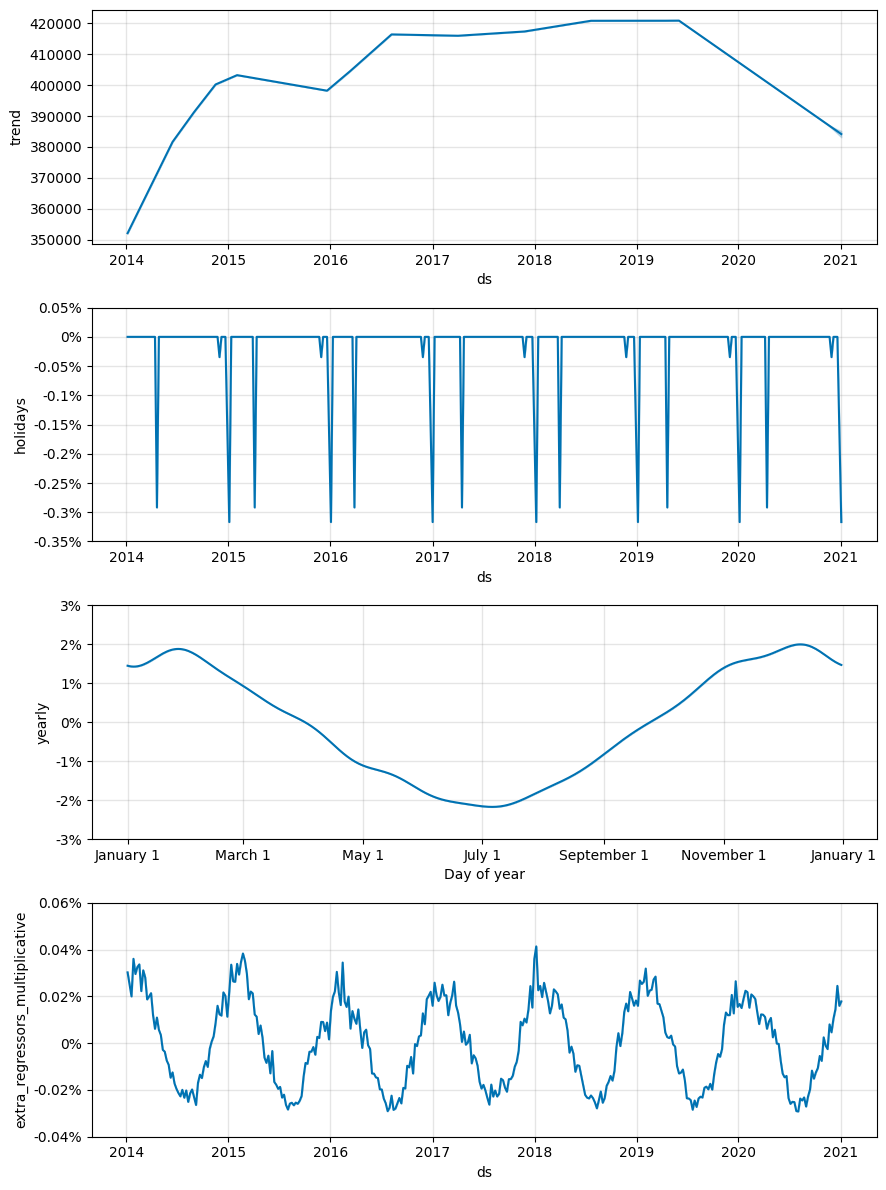

In [173]:
#model components
m.plot_components(forecast);

#Parameter Tuning and Model Optimization

In [174]:
#Cross Validation

df_cv = cross_validation(m,
                         horizon = "12 W",
                         initial = "250 W",
                         parallel = 'processes')

INFO:prophet:Making 16 forecasts with cutoffs between 2018-10-28 00:00:00 and 2020-07-19 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7827226885b0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjg2eonk7/yyiq8zaw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjg2eonk7/bfscnnac.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjg2eonk7/vfr08p91.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjg2eonk7/0lrp4jtl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22574', 'data', 'file=/tmp/tmpjg2eonk7/yyiq8zaw.json', 'init=/tmp/tmpjg2eonk7/vfr08p91.json', 'output', 'file=/tmp/tmpjg2eonk7/prophet_modeleqbw2ucb/prophet_model-20240104194328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:43:28 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdstanpy:runnin

In [175]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-11-04,427256.432162,426033.232108,428392.857027,425791,2018-10-28
1,2018-11-11,427925.342117,426736.298067,429259.164350,426652,2018-10-28
2,2018-11-18,428325.980448,427083.618800,429520.339710,427596,2018-10-28
3,2018-11-25,428657.467196,427413.439683,429935.158830,426587,2018-10-28
4,2018-12-02,429062.227798,427629.683506,430376.938599,426032,2018-10-28
...,...,...,...,...,...,...
187,2020-09-13,399928.442148,397873.750864,401927.864849,381309,2020-07-19
188,2020-09-20,401106.472730,399029.271939,403216.064474,380963,2020-07-19
189,2020-09-27,401890.709158,399703.929338,404190.872582,379435,2020-07-19
190,2020-10-04,402536.357487,400229.361251,404881.609981,378631,2020-07-19


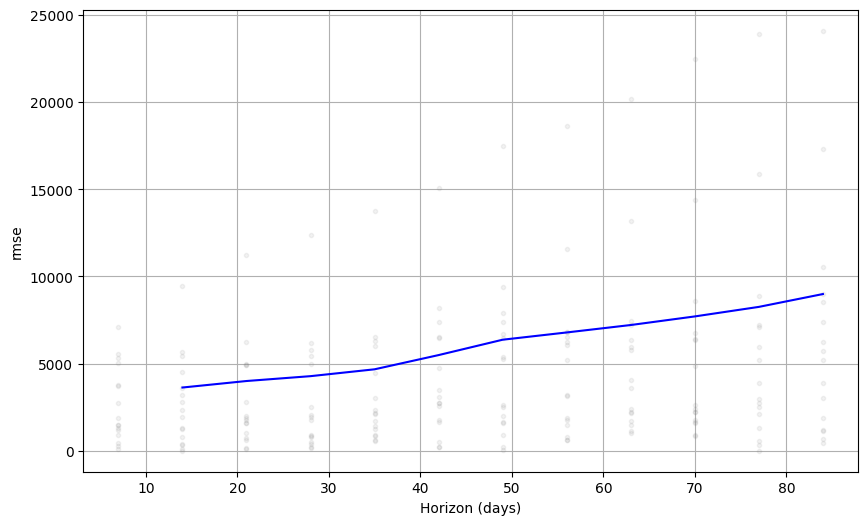

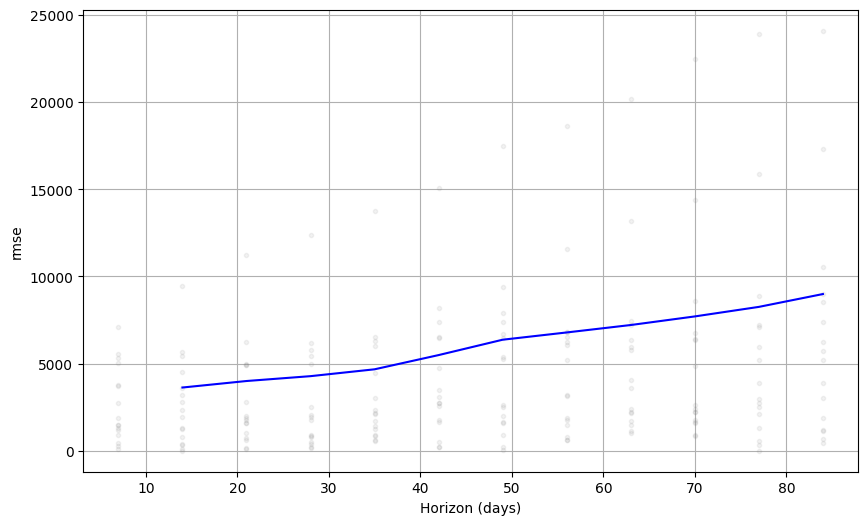

In [176]:
#Visualizing Cross Validation Results

plot_cross_validation_metric(df_cv, metric = "rmse")

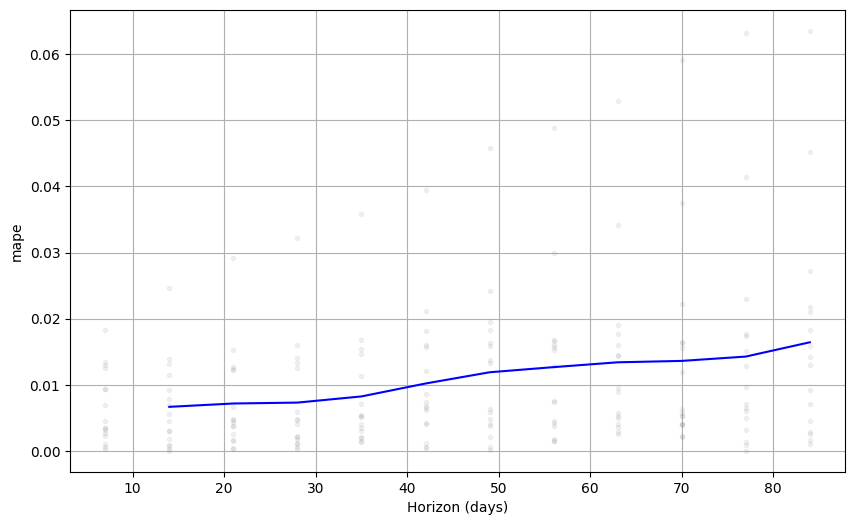

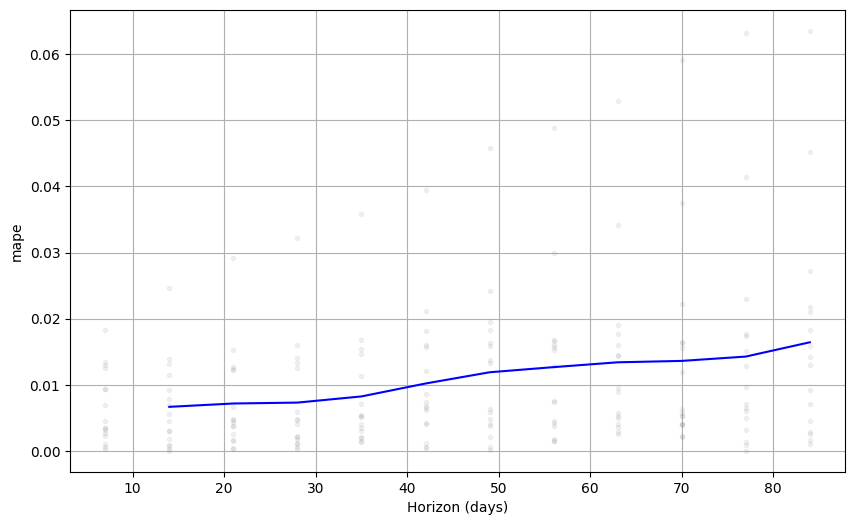

In [177]:
plot_cross_validation_metric(df_cv, metric = "mape")

In [178]:
#Create the parameter grid

param_grid = {'seasonality_mode': ['additive','multiplicative'],
              'seasonality_prior_scale':[5,10,20,30],
              'holidays_prior_scale': [5,10,20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)

In [179]:
print("number of potential outcomes: ", len(list(grid)))

number of potential outcomes:  72


In [180]:
#Parameter Tuning loop

#Store results
rmse = []


for params in grid:

  #build and fit model to the training set
  m = Prophet(growth = 'linear',
              yearly_seasonality = True,
              weekly_seasonality = False,
              holidays = holidays,
              seasonality_mode = params['seasonality_mode'],
              seasonality_prior_scale = params['seasonality_prior_scale'],
              holidays_prior_scale = params['holidays_prior_scale'],
              changepoint_prior_scale = params['changepoint_prior_scale'])
  m.add_regressor("Temperature", mode='multiplicative')
  m.fit(train_data)

  #Cross Validation
  df_cv = cross_validation(m,
                           horizon = '12 W',
                           initial = '250 W',
                           parallel = 'processes')

  #Calculate error and add to storage
  err = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))
  rmse.append(err)

Streaming output truncated to the last 5000 lines.
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58412', 'data', 'file=/tmp/tmpjg2eonk7/ap39hufr.json', 'init=/tmp/tmpjg2eonk7/6t4tmpeh.json', 'output', 'file=/tmp/tmpjg2eonk7/prophet_model2021d0uu/prophet_model-20240104194854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:48:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:48:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
19:48:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjg2eonk7/cdd76vlw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjg2eonk7/qfosr50m.json
DEBUG:cmdstanpy:

In [181]:
#Take the best parameters from the output of the parameter tuning loop

tune_results = pd.DataFrame(grid)
tune_results['RMSE'] = rmse
tune_results.sort_values(by="RMSE").iloc[0]

changepoint_prior_scale            0.1
holidays_prior_scale                 5
seasonality_mode              additive
seasonality_prior_scale             30
RMSE                       6133.148368
Name: 51, dtype: object

#Model with optimized parameters

In [182]:
m_final = Prophet(growth = 'linear',
                  yearly_seasonality = True,
                  weekly_seasonality = False,
                  holidays = holidays,
                  seasonality_mode = 'additive',
                  seasonality_prior_scale = 20,
                  holidays_prior_scale = 5,
                  changepoint_prior_scale = 0.1)
m_final.add_regressor("Temperature", mode='multiplicative')
m_final.fit(train_data)

df_cv = cross_validation(m_final,
                           horizon = '12 W',
                           initial = '250 W',
                           parallel = 'processes')
rmse_final = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))
mae_final = mean_absolute_error(df_cv['y'], df_cv['yhat'])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjg2eonk7/u8ocz652.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjg2eonk7/87u1g334.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85403', 'data', 'file=/tmp/tmpjg2eonk7/u8ocz652.json', 'init=/tmp/tmpjg2eonk7/87u1g334.json', 'output', 'file=/tmp/tmpjg2eonk7/prophet_model1n8dcjl6/prophet_model-20240104195422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:54:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:54:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2018-10-28 00:00:00 and 2020-07-19 00:00:00
INFO:prophet:Applying in parallel with <conc

In [183]:
print("RMSE Final: ", rmse_final)
print("MAE Final: ", mae_final)

RMSE Final:  6134.157591436536
MAE Final:  4156.6499422758625


In [184]:
#Calculate mean and std of the target variable to put perspective around the error from our model

print("Mean of Total Individuals in Shelter: ", np.mean(df['y']))
print("Std of Total Individuals in Shelter: ", np.std(df['y']))

Mean of Total Individuals in Shelter:  405042.8087431694
Std of Total Individuals in Shelter:  19349.021744987807


In [185]:
#With the final model, let's predict a year into the future compared to just 3 months
#If we create this dataframe beyond period = 12, the values for Temperature will be null so we need to use this dataframe to add temperature values for the period into the future
future = m_final.make_future_dataframe(periods = 12,
                                 freq = 'W')
future_df = pd.concat([future, df.iloc[:,2:]],
                      axis=1)
future_df

,ds,Temperature
0,2014-01-05,0.848000
1,2014-01-12,3.257143
2,2014-01-19,5.632857
3,2014-01-26,-1.850000
4,2014-02-02,1.177143
...,...,...
361,2020-12-06,10.072857
362,2020-12-13,8.208571
363,2020-12-20,3.535714
364,2020-12-27,7.510000


<Axes: >

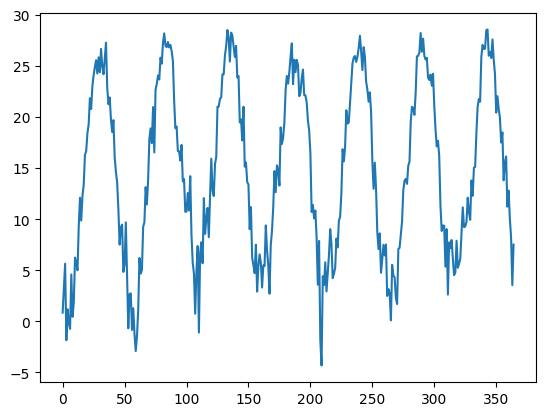

In [186]:
future_df['Temperature'].iloc[0:365].plot()

In [187]:
#Using the periodic nature of temperature to add to the temperature data for one year into the future

temp_cycle_length = 52
cyclic_pattern = future_df['Temperature'].tail(52).values
extended_temperature_values = []
extended_period = 52

for i in range(extended_period):
  extended_temperature_values.append(cyclic_pattern[i % temp_cycle_length])

present_temp_values = future_df['Temperature'].values.tolist()
temp_with_extension = [present_temp_values + extended_temperature_values][0]
#temp_with_extension = temp_with_extension[:-temp_cycle_length]
print(len(temp_with_extension))
print(temp_with_extension)

418
[0.848, 3.257142857, 5.632857143, -1.85, 1.177142857, -0.207142857, -0.738571429, 4.575714286, 0.438571429, 1.845714286, 6.228571429, 5.651428571, 4.988571429, 9.325714286, 12.08571429, 9.847142857, 12.27857143, 13.32285714, 16.26428571, 16.63714286, 18.38714286, 19.25, 21.81142857, 20.76285714, 22.97142857, 24.05142857, 24.86714286, 25.52571429, 24.23, 25.80714286, 24.35571429, 26.63571429, 24.90857143, 24.16, 25.71857143, 27.24571429, 22.83714286, 21.22285714, 21.88857143, 19.71714286, 18.50428571, 19.67285714, 16.07, 14.61857143, 13.58, 10.91, 7.501428571, 9.202857143, 9.451428571, 4.831428571, 5.525714286, 9.67, 4.68, -0.681428571, 2.64, 2.732857143, -0.841428571, 1.281428571, -1.228571429, -2.91, -1.48, 1.117142857, 6.192857143, 4.67, 5.022857143, 9.235714286, 9.672857143, 13.11714286, 11.42, 13.85142857, 17.81142857, 18.86142857, 17.42428571, 20.94857143, 16.51, 22.65714286, 23.21285714, 24.03714286, 23.64857143, 25.77857143, 25.19857143, 27.22428571, 28.15571429, 26.97142857

In [188]:
future_df['Temperature']

0       0.848000
1       3.257143
2       5.632857
3      -1.850000
4       1.177143
         ...    
361    10.072857
362     8.208571
363     3.535714
364     7.510000
365     6.625000
Name: Temperature, Length: 366, dtype: float64

In [189]:
#Recreate the future dataframe with a period of 52 weeks

future = m_final.make_future_dataframe(periods = 52,
                                 freq = 'W')
future_df = pd.concat([future, df.iloc[:,2:]],
                      axis=1)
future_df

,ds,Temperature
0,2014-01-05,0.848000
1,2014-01-12,3.257143
2,2014-01-19,5.632857
3,2014-01-26,-1.850000
4,2014-02-02,1.177143
...,...,...
401,2021-09-12,NaN
402,2021-09-19,NaN
403,2021-09-26,NaN
404,2021-10-03,NaN


In [190]:
temp_with_extension = temp_with_extension[:len(future_df)]

In [191]:
len(temp_with_extension)

406

In [192]:
future_df['Temperature'] = temp_with_extension
future_df

,ds,Temperature
0,2014-01-05,0.848000
1,2014-01-12,3.257143
2,2014-01-19,5.632857
3,2014-01-26,-1.850000
4,2014-02-02,1.177143
...,...,...
401,2021-09-12,24.185714
402,2021-09-19,20.405714
403,2021-09-26,22.010000
404,2021-10-03,20.775714


<Axes: >

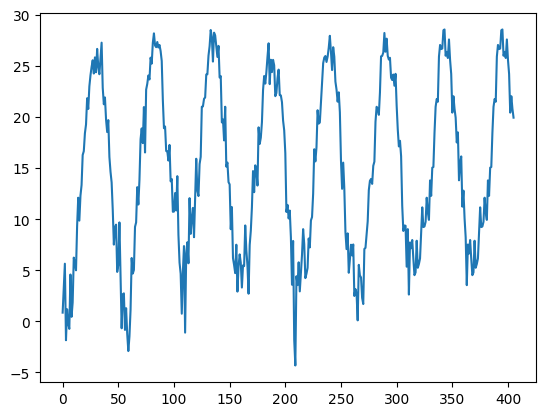

In [193]:
#The extension holds the cyclical pattern of the temperature over the extended period
future_df['Temperature'].plot()

In [194]:
#Forecasting with the extended data
forecast_final = m_final.predict(future_df)

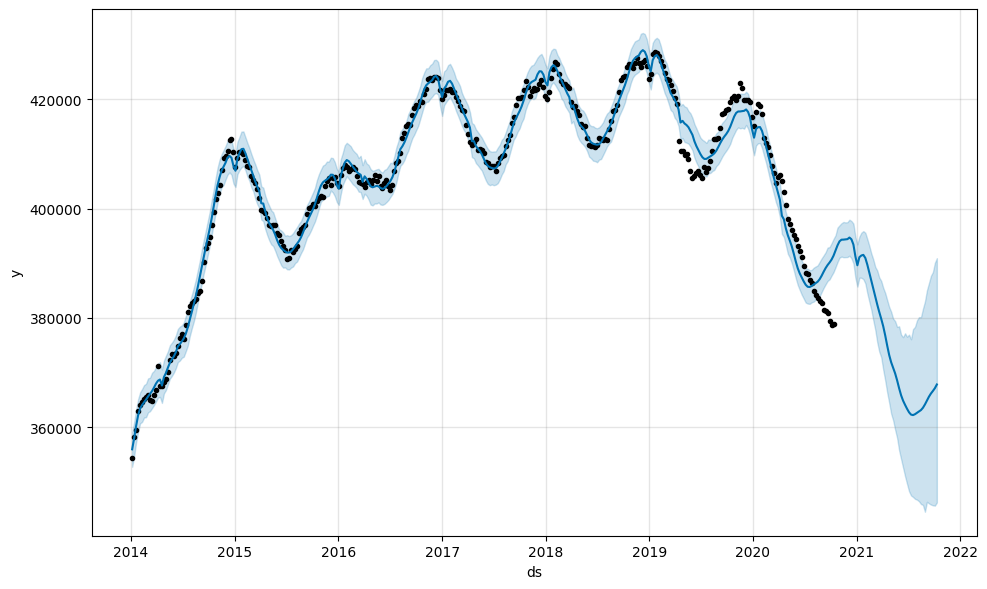

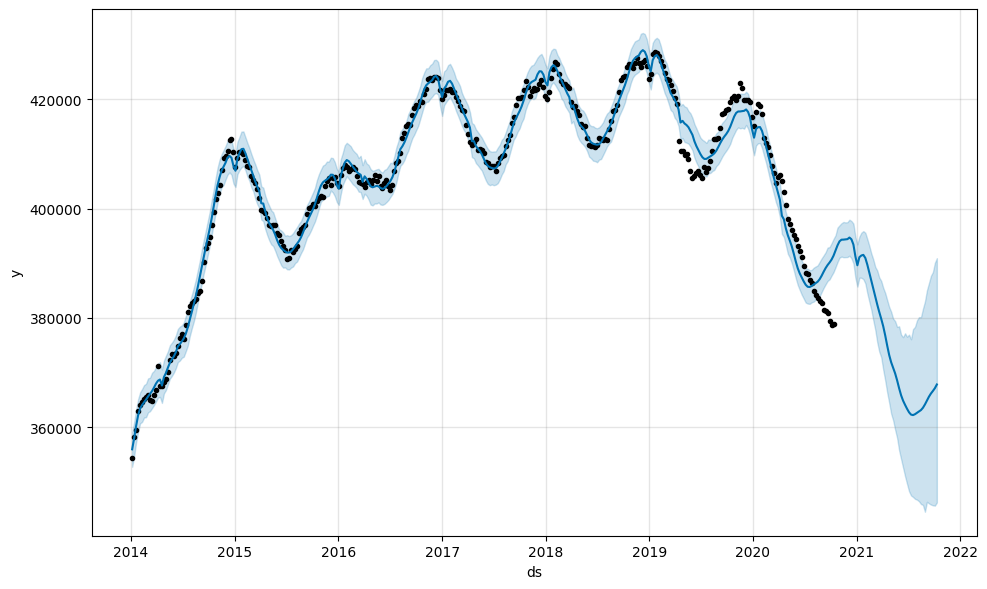

In [195]:
m_final.plot(forecast_final)

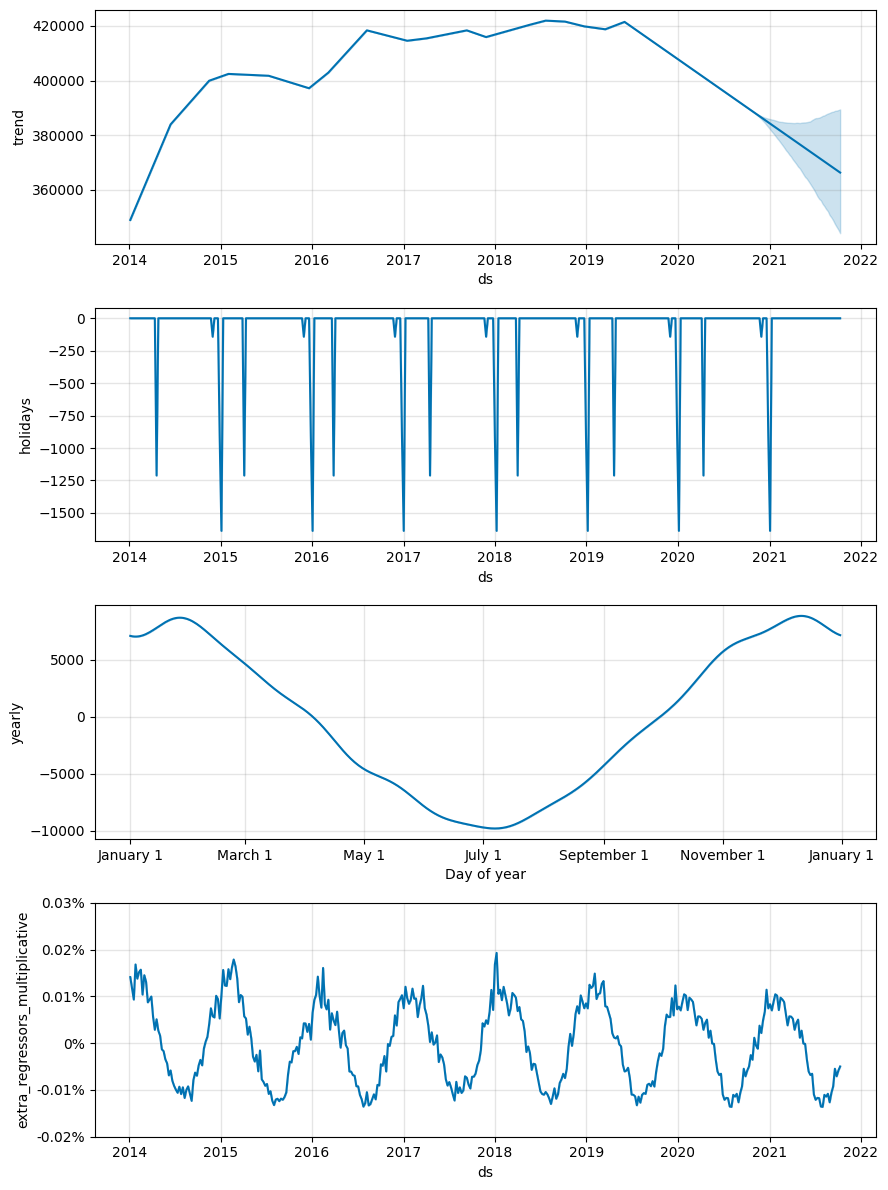

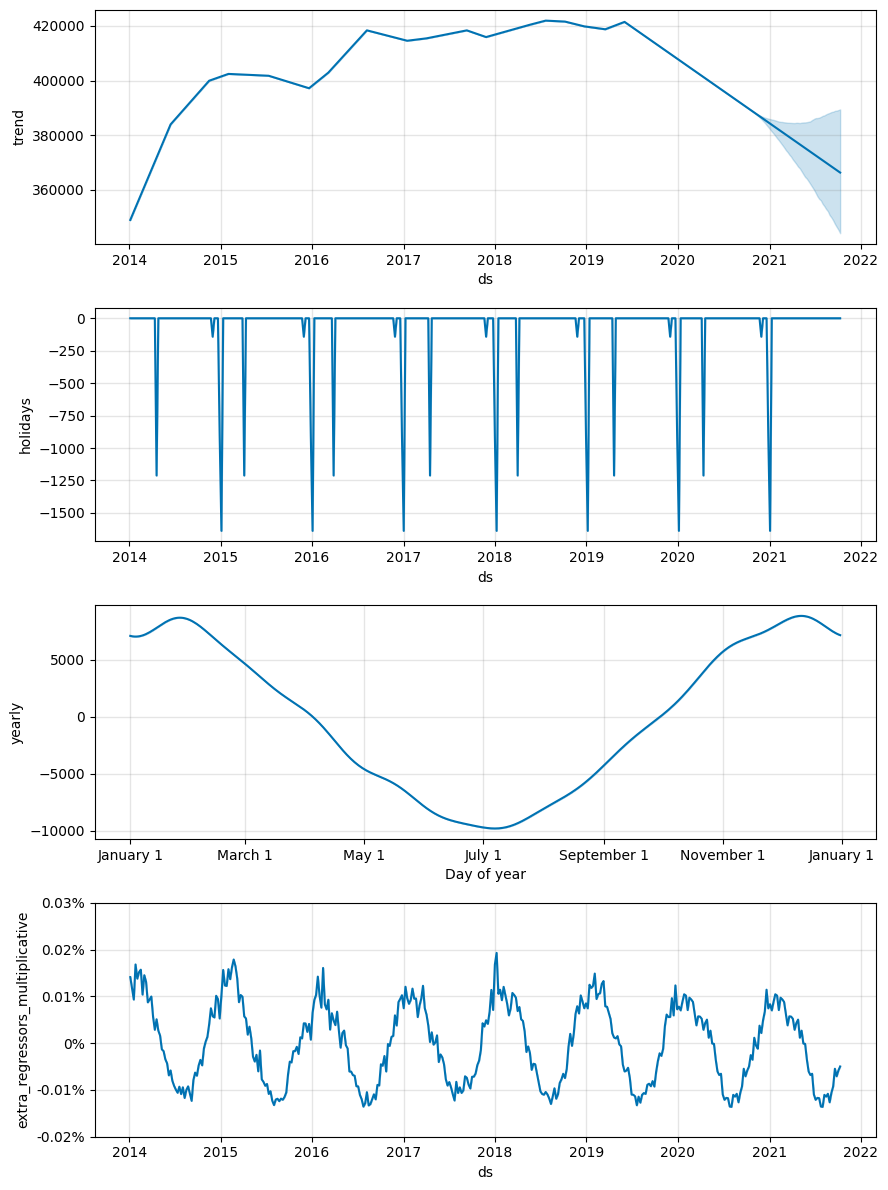

In [196]:
m_final.plot_components(forecast_final)

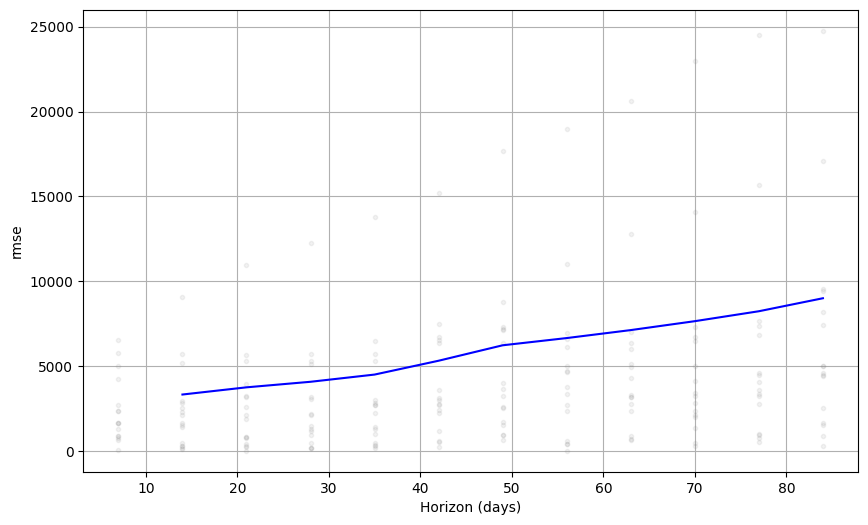

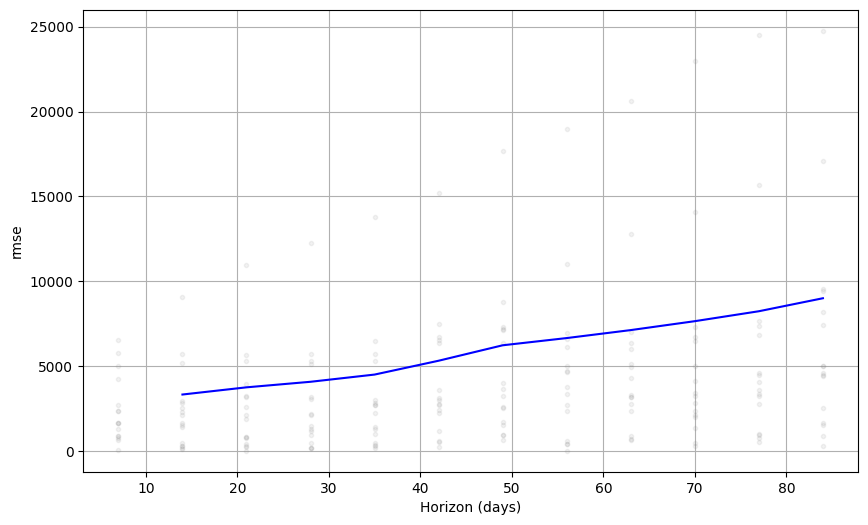

In [197]:
#Visualizing results of cross validation with the optimized model (viewing metric = RMSE)

plot_cross_validation_metric(df_cv, metric = "rmse")

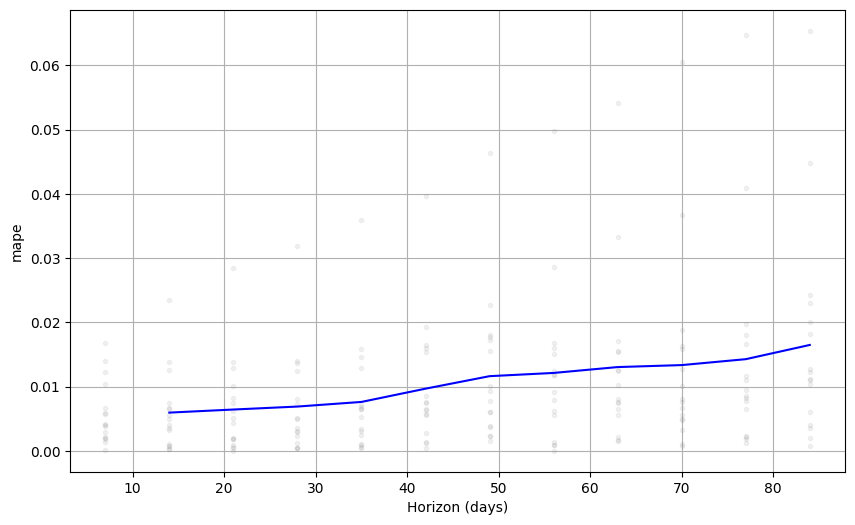

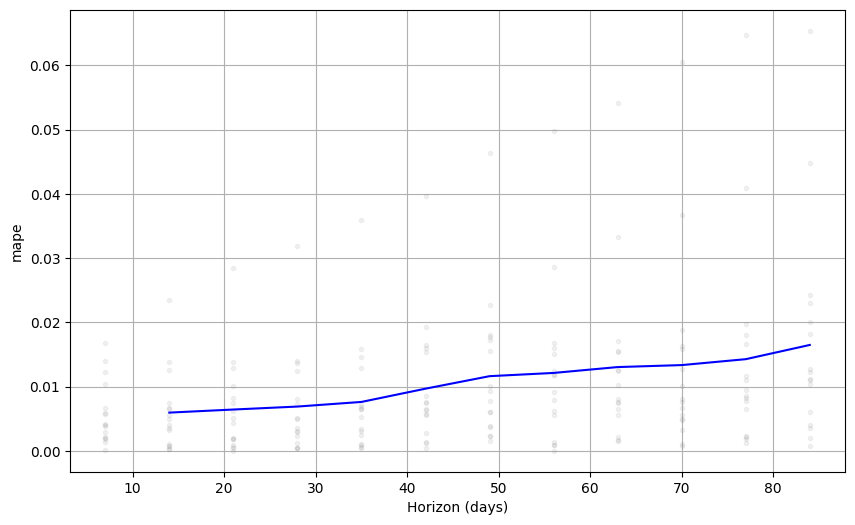

In [198]:
#Same with metric = MAPE

plot_cross_validation_metric(df_cv, metric = "mape")

In [199]:
forecast_final[['ds','yhat','yhat_lower','yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
399,2021-08-29,364151.452926,344500.532959,383014.416142
400,2021-09-05,364874.522197,346324.741552,385046.532417
401,2021-09-12,365563.191685,346040.351750,386360.044799
402,2021-09-19,366146.763431,345817.244095,387700.893734
403,2021-09-26,366620.534033,345683.390086,388394.975230
404,2021-10-03,367132.099948,345624.160678,390093.893942
405,2021-10-10,367809.954747,346204.855995,390944.347207


In [200]:
#Referenced daily DHS data to calculate the total number of individuals in shelter from 9/12/2021 - 9/19/2021
total_912_919 = 45305
total_912_919

45305

In [201]:
#Difference in prediction
(forecast_final.iloc[402]['yhat'] // 7) - total_912_919

7001.0

In [202]:
forecast_final[['ds','yhat','yhat_lower','yhat_upper']].iloc[386:395]

,ds,yhat,yhat_lower,yhat_upper
386,2021-05-30,367128.109642,355755.967484,378468.146291
387,2021-06-06,365833.574031,354156.155776,376929.880678
388,2021-06-13,364844.760324,352577.782248,376475.626731
389,2021-06-20,364076.854912,351003.174626,377186.492885
390,2021-06-27,363357.063578,349607.260191,376544.522535
391,2021-07-04,362714.489075,348263.088687,376937.512022
392,2021-07-11,362295.655019,347492.680741,376094.665354
393,2021-07-18,362205.251615,347217.731543,377946.918565
394,2021-07-25,362368.658700,346871.141784,378356.262059


In [203]:
#DHS total from 6/21/2021 - 6/27/2021
total_621_627 = 47521
(forecast_final.iloc[390]['yhat'] // 7) - total_621_627

4387.0

In [204]:
#Differences in the predicted and actual averages for June and September

june_average_pred = forecast_final.iloc[387:391]['yhat'].sum() // 30
sept_average_pred = forecast_final.iloc[400:404]['yhat'].sum() // 30

print("June Daily Prediction: ", june_average_pred)
print("September Daily Prediction: ", sept_average_pred)

print("June Error: ", abs(june_average_pred - 48093))
print("September Error: ", abs(sept_average_pred - 45224))

June Daily Prediction:  48603.0
September Daily Prediction:  48773.0
June Error:  510.0
September Error:  3549.0


#Final Model Prediction Analysis

##Based on the predictions made for 6 months and a year into the future from the end of our dataset, the model seems to have performed decently well. In June 2021, the daily average of total individuals in homeless shelters was 48,093. In September 2021, that number was 45,224. When making predictions for the daily average of individuals in shelter over the span of a month, the model is quite accurate. We see more error as we try to predict on a weekly basis, but this value is likely much less important in practice. We also see more error in september compared with June, which can be attributed to a few factors. For one, September is farther into the future than June, and as we move farther into the future with our predictions we expect the error to increase. This can also be demonstrated in the code cell that shows the model's RMSE over time `plot_cross_validation_metric()` showing that the cross validation error on test data that is increasingly farther into the future has an uptrend. The confidence interval on the plot showing the forecast also dramatically widens with time. The other reason is that the "Temperature" regressor added to the model likely makes prediction in the summer and winter months easier compared with fall and spring months where the temperature has higher variance.

#Conclusion and Future Work

##Meta's Prophet software is a powerful tool for time series forecasting tasks, and it was great to learn how it can be applied to a real-world problem. That being said, there are several additional things that can be done in order to make this particular model more robust and to keep in mind when working with Prophet in the future.

## Data:
###This dataset contained records on a weekly basis, compared to daily which is also publicly available. This data setNext steps likely include collecting the data recorded on a data basis and building a time series model using that dataset. The larger number of data points in the training data could allow the model to better capture patterns.

###Further investigation can be done into what caused the drop off in those staying in homeless shelters from 2020 onward, although a guess can be made that it had to do with the breakout of the COVID-19 pandemic.

## Model parameters and parameter tuning:
###A lot of parameter tuning and model optimization was done in this study, but there are definitely more parameters that are provided by the Prophet library that could help to improve performance. Digging deeper into the documentation will help to harness the full power of this already great library.

##Future Forecasting
###The daily homeless shelter data that is released by the DHS contains records up to present day. Using that data to build another forecasting model that can make predictions into the actual future (not just the end of the dataset), could make the model much more useful in practice.